<a href="https://colab.research.google.com/github/Jumarti96/Some-projects/blob/main/5_multivariable_time_series_models_for_COP_USD_exchange_rate_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***5 Multivariable Time-series Models for COP/USD Exchange Rate Forecasting***

The purpose of this notebook is to show how to perform exchange rate forecasting employing multivariable time-series models. The data used in this project is real data, gathered mostly from the [FRED (Federal Reserve Economic Data)](https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/) database, plus a few other sources for exchange rates and commodity prices. The variables used are also common variables from exchange rate literature, so that although the models can clearly be improved, they serve as useful starting points for anyone wanting to dig deeper into exchange rate forecasting.

The models performed in this project are the following:


* Multivariate regression on the mean
* SARIMAX (Seasonal Auto-Regressive Integrated Moving Average  with explanatory variables)
* VAR (Vector Auto-Regressive)
* VARMA (Vectore Auto-Regressive Moving Average)
* RNN (Recurrent Neural Networks)



# ***1. Importing necessary libraries***

Some libraries you might not have installed. Add here any other library used in the notebook that is not installed in your environment.

In [32]:
pip install pmdarima==2.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pandas_datareader import data as pdr
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

# ***2. Data gathering***

In [8]:
vars = [
    'COLCCUSMA02STM', 'COLIRSTCI01STM', 'FEDFUNDS',
    'COLIRLTLT01STM', 'IRLTLT01USM156N', 'COLCPALTT01GPM',
    'MEDCPIM158SFRBCLE', 'RBCOBIS', 'RBUSBIS'
    ]
vars_daily = ['DCOILBRENTEU']

start_date = '2000-01-01'

data = pdr.DataReader(vars, data_source='fred', start=start_date)
data_daily = pdr.DataReader(vars_daily, data_source='fred',
                            start=start_date).resample('MS').mean()

data.rename(columns={"COLCCUSMA02STM":"COPvUSD", 
                     "COLIRSTCI01STM":"COL_liqrate",
                     "FEDFUNDS":"US_liqrate", 
                     "COLIRLTLT01STM":"COL_10Ybondrate",
                     "IRLTLT01USM156N":"US_10Ybondrate", 
                     "COLCPALTT01GPM":"COL_CPI",
                     "MEDCPIM158SFRBCLE":"US_CPI",
                     "RBCOBIS":"COL_REER",
                     "RBUSBIS":"US_REER"}, inplace=True)
data_daily.rename(columns={"DCOILBRENTEU":"Brent_price"}, inplace=True)

df = data.merge(data_daily, how='left', left_index=True, right_index=True)

In [9]:
df['COL_CPI'] = df['COL_CPI'].rolling(12).sum()
df['COPvUSD_sta'] = df['COPvUSD'].diff()

# ***3. Data pre-processing***

We already have the necessary variables, however, with some creativity and reasoning, we can think of some new features we can create that could be useful at predicting the exchange rate. I think some of the following can help with our objective, and later we can do some analysis using these and 

In [11]:
# Creation of some new features
df['yield_gap'] = df['COL_10Ybondrate'] - df['US_10Ybondrate']
df['yield_ratio'] = df['COL_10Ybondrate']/df['US_10Ybondrate']
df['yield_gap2'] = df['COL_10Ybondrate']**2 - df['US_10Ybondrate']**2
df['yield_ratio2'] = (df['COL_10Ybondrate']**2)/(df['US_10Ybondrate']**2)

df['liqrate_gap'] = df['COL_liqrate'] - df['US_liqrate']
df['liqrate_ratio'] = df['COL_liqrate']/df['US_liqrate']
df['liqrate_gap2'] = df['COL_liqrate']**2 - df['US_liqrate']**2
df['liqrate_ratio2'] = (df['COL_liqrate']**2)/(df['US_liqrate']**2)

In [12]:
# Dataframe with differenced variables
df_diff = df.diff().copy()

Thinking about making this project easy to replicate, I'm also setting an end_date to cut the data. This is to make sure that users can run all the code in this notebook without issues of missing data.

I chose '2022-09-01' as the end_date, which is the last date for which I ran the models.

Note: this piece of code should be optional, as the code is expected to run just fine without any end_date given that that the sources for the data are updated regularly for all the variables, so feel free to ommit these lines if you want to run the code with up-to-date data and enable it if for some reason it doesn't work as expected.

In [13]:
end_date = '2022-12-01'
df = df.loc['2004-01-01':end_date]
df_diff = df_diff.loc['2004-01-01':end_date]

In [14]:
financial_crisis = pd.DataFrame({"Fin_crisis":0}, index=df.index)
covid_crisis = pd.DataFrame({"Cov_crisis":0}, index=df.index)

financial_crisis.loc['2007-10-01':'2009-06-01'] = 1
covid_crisis.loc['2020-03-01':'2020-10-01'] = 1

df['Fin_crisis'], df['Cov_crisis'] = financial_crisis, covid_crisis
df_diff['Fin_crisis'], df_diff['Cov_crisis'] = financial_crisis, covid_crisis

# Create a flag for November and December
df['temp_date'], df_diff['temp_date'] = df.index, df_diff.index
df['EOY'] = df['temp_date'].apply(lambda x: 1 if str(x).split('-')[1] in ('11', '12') else 0)
df_diff['EOY'] = df_diff['temp_date'].apply(lambda x: 1 if str(x).split('-')[1] in ('11', '12') else 0)
df.drop(columns='temp_date', inplace=True), df_diff.drop(columns='temp_date', inplace=True)


(None, None)

Train, validation and test sets for level and differenced variables.

In [39]:
train_df = df.iloc[:-6].copy()
val_df = df.iloc[-6:-3].copy()
test_df = df.iloc[-3:].copy()

train_diff = df_diff.iloc[:-6].copy()
val_diff = df_diff.iloc[-6:-3].copy()
test_diff = df_diff.iloc[-3:].copy()

In [42]:
test_diff

,COPvUSD,COL_liqrate,US_liqrate,COL_10Ybondrate,US_10Ybondrate,COL_CPI,US_CPI,COL_REER,US_REER,Brent_price,...,yield_ratio,yield_gap2,yield_ratio2,liqrate_gap,liqrate_ratio,liqrate_gap2,liqrate_ratio2,Fin_crisis,Cov_crisis,EOY
DATE,,,,,,,,,,,,,,,,,,,,,
2022-07-01,438.883169,1.44,0.47,1.01,-0.24,0.486641,-1.501308,-7.60,1.78,-10.785238,...,0.654272,25.9219,5.266350,0.97,-0.543979,18.1681,-5.152866,0,0,0
2022-08-01,-65.130019,1.52,0.65,-0.41,0.00,0.574355,2.040306,1.44,-0.51,-11.479351,...,-0.141379,-10.1803,-1.210499,0.87,-0.593041,22.5039,-4.943312,0,0,0
2022-09-01,121.905032,0.05,0.23,0.71,0.62,0.546955,-0.080953,-0.20,2.56,-10.681602,...,-0.539890,13.8619,-4.254767,-0.18,-0.328276,-0.2202,-2.433907,0,0,0


# ***4. Analysis of the data***

## ***4.1 Some plots***

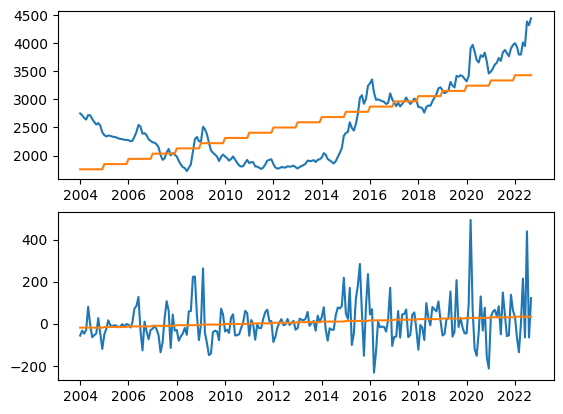

In [16]:
#A few plots

fig, axes = plt.subplots(2, 1)

reg_1 = sm.OLS(df['COPvUSD'], sm.add_constant(df.index.year)).fit()
predictions_1 = reg_1.predict(sm.add_constant(df.index.year))       # To plot trend of level series
reg_2 = sm.OLS(df['COPvUSD_sta'], sm.add_constant(df.index.year)).fit()
predictions_2 = reg_2.predict(sm.add_constant(df.index.year))       # To plot trend of stationary series

axes[0].plot(df['COPvUSD'])
axes[1].plot(df['COPvUSD_sta'])
axes[0].plot(pd.DataFrame(predictions_1, index=df.index))
axes[1].plot(pd.DataFrame(predictions_2, index=df.index))

plt.show()

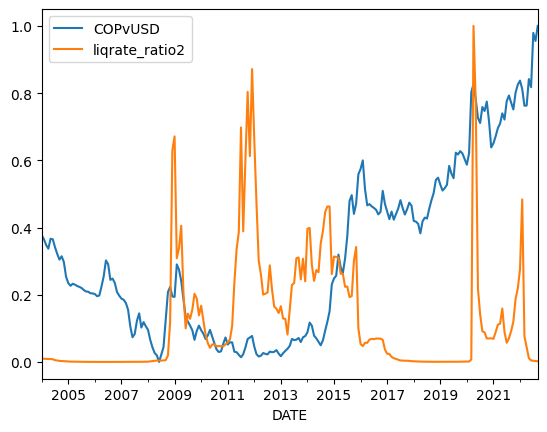

In [17]:
# Plot any desired variable against exchange rate
df_min, df_max = df.min(), df.max()
df_norm = (df - df_min) / (df_max - df_min)
df_norm[['COPvUSD', 'liqrate_ratio2']].plot()
plt.show()

In [24]:
# Stationarity of COP/USD
print("Augmented Dickey Fuller Test for non-stationarity of level COP/USD series: \n" + str(adfuller(df['COPvUSD'])))         # COP/USD non-stationary with 98% probability
print("\n")
print("Augmented Dickey Fuller Test for non-stationarity of differenced COP/USD series: \n" + str(adfuller(df['COPvUSD_sta'])))     # COP/USD_sta  non-stationary with <1% probability

Augmented Dickey Fuller Test for non-stationarity of level COP/USD series: 
(0.8732343791474348, 0.9927308950294106, 3, 221, {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}, 2486.931732104413)


Augmented Dickey Fuller Test for non-stationarity of differenced COP/USD series: 
(-5.596652832260636, 1.2924605633865629e-06, 4, 220, {'1%': -3.4604283689894815, '5%': -2.874768966942149, '10%': -2.57382076446281}, 2485.7176789599994)


## ***4.2 Analysis of correlations***

In [29]:
n_lags = 20
corrs = pd.DataFrame(columns=df.columns.values, index=range(n_lags))
corrs.drop(columns=['COPvUSD_sta', 'Fin_crisis', 'Cov_crisis'], inplace=True)
main_var = 'COPvUSD'#'COPvUSD'    # 'COL_REER', 'COPvUSD'

for var in corrs.columns:
    correlations=[]
    for i in range(n_lags):
        corr_value = np.corrcoef(df[main_var].values[i:], df[var].shift(i).values[i:])[0, 1]
        correlations.append(corr_value)
    corrs[var] = correlations


corrs   #sns.heatmap(corrs)

,COPvUSD,COL_liqrate,US_liqrate,COL_10Ybondrate,US_10Ybondrate,COL_CPI,US_CPI,COL_REER,US_REER,Brent_price,yield_gap,yield_ratio,yield_gap2,yield_ratio2,liqrate_gap,liqrate_ratio,liqrate_gap2,liqrate_ratio2,EOY
0,1.000000,-0.198364,-0.083235,-0.091822,-0.445433,0.288429,0.526308,-0.845810,0.913393,-0.459661,0.167321,0.591637,-0.017299,0.534019,-0.155633,-0.205326,-0.136197,-0.195923,-0.001388
1,0.991381,-0.226501,-0.099753,-0.127121,-0.464319,0.258488,0.516820,-0.827441,0.902826,-0.450457,0.134884,0.584482,-0.052627,0.525719,-0.172551,-0.195322,-0.164048,-0.189569,-0.008523
2,0.979466,-0.256596,-0.115932,-0.162591,-0.477094,0.226837,0.504864,-0.804040,0.887274,-0.441932,0.097967,0.569505,-0.087523,0.510121,-0.191829,-0.182971,-0.194400,-0.181268,-0.011406
3,0.968349,-0.279673,-0.129541,-0.195798,-0.487842,0.196001,0.492212,-0.780860,0.870973,-0.440961,0.063110,0.556664,-0.120598,0.497901,-0.205929,-0.167294,-0.213604,-0.168913,-0.002911
4,0.960525,-0.296967,-0.139961,-0.223839,-0.504365,0.163942,0.468281,-0.763821,0.855991,-0.447303,0.037723,0.554663,-0.145922,0.495528,-0.216533,-0.155835,-0.225249,-0.160891,-0.006726
5,0.952985,-0.315620,-0.145892,-0.252664,-0.519806,0.130384,0.444749,-0.746688,0.839919,-0.449987,0.009922,0.551891,-0.172698,0.492089,-0.232837,-0.145223,-0.239394,-0.151782,-0.009928
6,0.943801,-0.330876,-0.147437,-0.282091,-0.534895,0.091350,0.431862,-0.728322,0.822685,-0.446689,-0.019135,0.548952,-0.200618,0.489964,-0.249167,-0.141454,-0.250371,-0.148446,-0.011294
7,0.932604,-0.341282,-0.147855,-0.309152,-0.545925,0.052377,0.417943,-0.708642,0.802348,-0.453599,-0.048506,0.540979,-0.225640,0.482107,-0.260586,-0.141726,-0.257467,-0.149923,-0.006622
8,0.921703,-0.352598,-0.147362,-0.329583,-0.554078,0.014320,0.403261,-0.689375,0.784451,-0.450983,-0.071362,0.532407,-0.243630,0.473727,-0.273877,-0.159962,-0.265712,-0.174874,0.015546
9,0.913478,-0.359064,-0.147766,-0.350386,-0.561423,-0.021829,0.388076,-0.673138,0.769624,-0.446910,-0.095690,0.526870,-0.262503,0.471315,-0.280273,-0.163385,-0.270249,-0.175939,0.033784


In [36]:
n_lags = 20
corrs = pd.DataFrame(columns=df_diff.columns.values, index=range(n_lags))
corrs.drop(columns=['COPvUSD_sta', 'Fin_crisis', 'Cov_crisis'], inplace=True)
main_var = 'COPvUSD'    # 'COL_REER', 'COPvUSD'

for var in corrs.columns:
    correlations=[]
    for i in range(n_lags):
        corr_value = np.corrcoef(df_diff[main_var].values[i:], df_diff[var].shift(i).values[i:])[0, 1]
        correlations.append(corr_value)
    corrs[var] = correlations

corrs

,COPvUSD,COL_liqrate,US_liqrate,COL_10Ybondrate,US_10Ybondrate,COL_CPI,US_CPI,COL_REER,US_REER,Brent_price,yield_gap,yield_ratio,yield_gap2,yield_ratio2,liqrate_gap,liqrate_ratio,liqrate_gap2,liqrate_ratio2,EOY
0,1.000000,0.189595,-0.136550,0.368465,-0.101462,0.125761,-0.089883,-0.874515,0.592433,-0.469433,0.433402,0.420900,0.355011,0.353850,0.256586,0.029095,0.198255,0.027488,0.042722
1,0.188710,0.107842,0.094586,0.145874,0.050244,0.112525,0.025985,-0.202918,0.259478,-0.160228,0.133016,0.089620,0.118329,0.080926,0.052748,-0.048750,0.086453,-0.025682,-0.094245
2,-0.050303,0.166348,0.172233,-0.141126,-0.065639,0.035351,0.061957,0.018938,0.021108,0.015901,-0.121598,-0.078145,-0.134282,-0.085152,0.061864,-0.071097,0.120702,-0.052713,-0.062046
3,-0.137074,0.199352,0.023068,0.034836,0.145242,0.108754,0.065429,0.105849,-0.041611,0.010032,-0.024186,-0.145413,0.022297,-0.119405,0.164550,0.070227,0.161096,0.051553,0.024504
4,-0.043500,0.044044,-0.089348,0.137068,0.038944,0.113613,-0.003875,0.073986,0.055173,0.075865,0.128727,0.015205,0.153769,0.020567,0.086428,-0.012072,0.067536,-0.014502,-0.069679
5,0.150682,0.148160,-0.092438,0.069057,0.057288,0.124379,-0.059657,-0.108190,0.136822,-0.033888,0.048982,-0.018321,0.079024,-0.039135,0.177211,0.033005,0.139281,0.045166,-0.065276
6,0.116271,0.094092,-0.018231,0.072204,0.118609,0.133723,-0.014315,-0.050795,0.170580,0.055224,0.027373,-0.029010,0.038302,0.009476,0.090230,0.008264,0.093944,0.030255,-0.051456
7,-0.058137,0.077852,-0.006271,-0.072494,-0.022418,0.074365,-0.008825,0.065417,-0.043588,0.044546,-0.067141,-0.015547,-0.073487,-0.013768,0.069990,-0.089011,0.082449,-0.069089,-0.005548
8,-0.167711,0.049314,0.069434,0.066704,0.049538,0.200186,-0.023069,0.127238,-0.144290,0.112084,0.049918,-0.140557,0.075820,-0.173809,0.003705,-0.115064,0.023042,-0.117454,0.128242
9,-0.059475,0.004066,-0.000015,0.042200,0.047734,0.076086,0.153414,0.023234,-0.048903,0.094520,0.024755,-0.124440,0.054737,-0.123423,0.003445,-0.042171,0.022900,-0.049632,0.097918


# ***5. Functions that will make our job easier***

Before modeling, there are some functions I like to create which make some steps easier.

The first of these functions is ***'invert_transformation'***, which takes a series that is either a difference transformation or a logarithmic transformation and turns it into a level series that we can interpret. This will be used once we make predictions with a transformed series.

In [47]:
# Create function to invert transformation
def invert_transformation(last_val, df_forecast,
                          last_val_1st_diff=None, second_diff=None, log_transformation=False):

    df_forecast = df_forecast.copy()

    if log_transformation == True:
        for col in df_forecast.columns:
            df_forecast[col] = last_val[col] + df_forecast[col].cumsum()
        df_forecast = np.exp(df_forecast)

    elif second_diff == True:
        for col in df_forecast.columns:
            df_forecast[col] = last_val_1st_diff[col] + df_forecast[col].cumsum()
            df_forecast[col] = last_val[col] + df_forecast[col].cumsum()

    else:
        for col in df_forecast.columns:
            df_forecast[col] = last_val[col] + df_forecast[col].cumsum()

    return df_forecast

# ***6. Multivariable regression on the mean model***

In [ ]:
"""First models"""
# Target variables: 'COPvUSD', 'COL_REER'
formula = 'COPvUSD ~ COL_liqrate + US_liqrate'
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()

formula = 'COPvUSD ~ COL_liqrate.shift(3) + US_liqrate.shift(3) + COPvUSD.shift(3) + COL_10Ybondrate.shift(3) + US_10Ybondrate.shift(3) + Brent_price.shift(3) + COL_CPI.shift(3) + US_CPI.shift(3) + Fin_crisis + Cov_crisis'
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()

formula = 'COPvUSD ~ US_liqrate.shift(1) + US_liqrate.shift(2) + US_liqrate.shift(3) + US_liqrate.shift(4) + US_liqrate.shift(5) + US_liqrate.shift(6) + US_liqrate.shift(12)'
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()


formula = 'COPvUSD ~ COL_liqrate.shift(1) + COL_liqrate.shift(2) + COL_liqrate.shift(3) + COL_liqrate.shift(4) + COL_liqrate.shift(5) + COL_liqrate.shift(6) + COL_liqrate.shift(12)'
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()

formula = ('COPvUSD ~'
           'US_liqrate.shift(1) + US_liqrate.shift(2) + US_liqrate.shift(3) + US_liqrate.shift(4) + US_liqrate.shift(5) + US_liqrate.shift(6) + US_liqrate.shift(12)'
           '+ COL_liqrate.shift(1) + COL_liqrate.shift(2) + COL_liqrate.shift(3) + COL_liqrate.shift(4) + COL_liqrate.shift(5) + COL_liqrate.shift(6) + COL_liqrate.shift(12)'
           )
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()


formula = ('COPvUSD ~ US_liqrate + COL_liqrate + COL_10Ybondrate + COL_CPI + Brent_price'
#           '+ COPvUSD.shift(1) + US_liqrate.shift(1) + COL_liqrate.shift(1) + COL_10Ybondrate.shift(1) + COL_CPI.shift(1) + Brent_price.shift(1)'
           )
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()

In [33]:
formula = ('COPvUSD ~'
           'US_liqrate.shift(1) + US_liqrate.shift(12)'
           '+ COL_liqrate.shift(1) + COL_liqrate.shift(2) + COL_liqrate.shift(3)'
           '+ COPvUSD.shift(1) + COPvUSD.shift(2)'
           '+ COL_10Ybondrate.shift(1) + COL_10Ybondrate.shift(12)'
           '+ COL_CPI.shift(4) + COL_CPI.shift(8)'
           '+ Brent_price.shift(1) + Brent_price.shift(8)'
#           '+ yield_gap.shift(1) + yield_gap2.shift(1)'
           '+ EOY.shift(8)'
           '+ Fin_crisis + Cov_crisis')
model = smf.ols(formula=formula, data=df_diff).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                COPvUSD   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     4.280
Date:                Wed, 03 May 2023   Prob (F-statistic):           3.88e-07
Time:                        00:23:06   Log-Likelihood:                -1234.7
No. Observations:                 213   AIC:                             2503.
Df Residuals:                     196   BIC:                             2561.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.4335      6.910      0.497      0.620     -10.195      17.062
US_liqrate.shift(1)         123.9443     43.313      2.862      0.005      38.525     209.363
US_liqrate.shift(12)       -128.0216     39.992     -3.201      0.002    -206.892     -49.152
COL_liqrate.shift(1)        -55.8412     27.364     -2.041      0.043    -109.807      -1.875
COL_liqrate.shift(2)         61.8984     29.123      2.125      0.035       4.465     119.332
COL_liqrate.shift(3)         52.4111     28.965      1.809      0.072      -4.712     109.534
COPvUSD.shift(1)              0.0233      0.078      0.298      0.766      -0.131       0.177
COPvUSD.shift(2)             -0.2094      0.069     -3.051      0.003      -0.345      -0.074
COL_10Ybondrate.shift(1)     36.7135     12.984      2.828      0.005      11.107      62.320
COL_10Ybondrate.shift(12)   -23.7324     11.649     -2.037      0.043     -46.706      -0.758
COL_CPI.shift(4)              8.0178     20.605      0.389      0.698     -32.619      48.655
COL_CPI.shift(8)             32.9240     20.658      1.594      0.113      -7.817      73.665
Brent_price.shift(1)         -3.4189      1.058     -3.232      0.001      -5.505      -1.333
Brent_price.shift(8)          1.4733      0.946      1.557      0.121      -0.393       3.339
EOY.shift(8)                 26.3329     15.673      1.680      0.095      -4.576      57.242
Fin_crisis                    3.0795     24.090      0.128      0.898     -44.430      50.589
Cov_crisis                   66.7194     32.989      2.022      0.044       1.660     131.779
==============================================================================
Omnibus:                       35.925   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.078
Skew:                           0.792   Prob(JB):                     1.11e-17
Kurtosis:                       5.507   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Prediction
preds = model.predict()         # Predictions of changes each period
start_val = df['COPvUSD'][-len(preds)-1]        # Take the value before the first prediction
preds[0] = preds[0] + start_val         # Sum the value before the first prediction to the first prediction
preds = preds.cumsum()          # Sum every change form that first value

comp_vals = df['COPvUSD'].iloc[-len(preds):]
MSE = np.sum((preds - comp_vals)**2)/len(comp_vals)
RMSE = np.sqrt(MSE)
WAPE = np.sum(np.abs(preds - comp_vals))/np.sum(comp_vals)


In [35]:
WAPE

0.18131774221049948

# ***7. VAR model***

In [44]:
"""
vars = ['COPvUSD', 'COL_liqrate', 'US_liqrate', 'COL_10Ybondrate',
       'US_10Ybondrate', 'COL_CPI', 'US_CPI', 'Brent_price'] #, 'Fin_crisis', 'Cov_crisis']
"""

vars = ['COPvUSD', 'US_liqrate', 'COL_10Ybondrate', 'COL_CPI', 'Brent_price']

In [46]:
# Lag selection
varmod = VAR(train_diff[vars])
lag_sel = varmod.select_order(12)
print(lag_sel.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.777       4.858       118.8       4.810
1       3.676*      4.159*      39.48*      3.871*
2        3.761       4.646       42.99       4.119
3        3.843       5.131       46.72       4.364
4        3.902       5.593       49.69       4.586
5        3.990       6.083       54.42       4.836
6        4.040       6.536       57.48       5.049
7        4.113       7.011       62.24       5.285
8        4.108       7.409       62.48       5.443
9        4.093       7.796       62.25       5.591
10       4.245       8.350       73.44       5.905
11       4.360       8.868       83.87       6.183
12       4.314       9.224       81.78       6.300
--------------------------------------------------


In [55]:
# VAR model with 2 lags
var_2l = VAR(train_diff[vars]).fit(maxlags=12)
var_2l.summary()



In [ ]:
preds = var_2l.forecast(train_diff[vars].values, steps=len(val_diff[vars]))
preds = pd.DataFrame(preds, columns=train_diff[vars].columns, index=val_diff[vars].index)

In [60]:
preds_df = invert_transformation(df.iloc[len(train_diff[vars])-1][train_diff[vars].columns],
                                 preds)

preds_df

,COPvUSD,US_liqrate,COL_10Ybondrate,COL_CPI,Brent_price
DATE,,,,,
2022-07-01,4389.144714,1.68,12.62,9.771199,111.925714
2022-08-01,4324.014696,2.33,12.21,10.345554,100.446364
2022-09-01,4445.919727,2.56,12.92,10.892509,89.764762


In [67]:
# Accuracy check
COPvUSDreal = val_df['COPvUSD']
COPvUSDpreds = preds_df['COPvUSD']
COPvUSDpreds.index = COPvUSDreal.index

accuracies = ((COPvUSDpreds/COPvUSDreal) - 1) * 100

accuracies

DATE
2022-04-01    0.948372
2022-05-01   -3.266742
2022-06-01    0.199125
Freq: MS, Name: COPvUSD, dtype: float64

In [69]:
# Month by month cumulative WAPE
WAPEs = []
abs_diff_sum = 0
actuals_sum = 0
for i in range(len(COPvUSDpreds)):
    abs_diff_sum += np.abs(COPvUSDreal[i] - COPvUSDpreds[i])
    actuals_sum += np.abs(COPvUSDreal[i])
    WAPEs.append(abs_diff_sum/actuals_sum)

WAPEs

[0.009483715919184458, 0.0213941559596059, 0.014880236636602942]

In [ ]:
np.sum(np.abs(COPvUSDreal - COPvUSDpreds))/np.sum(COPvUSDreal)